# Sartorius 

Dit is een onderzoek naar het autmoatiseren van de annotatie op hersen cellen.
Dit onderzoek is gestart om te zorgen dat doktoren meer tijd over hebben voor andere bezigheden.

Door groep 4
Danny Rovers, Thomas Hendriks en Liam Freke

In [1]:
#pip install opencv-python

In [2]:
import pandas as pd
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
import sys
import cv2
import seaborn as sns
import os
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image as im
from PIL import ImageFilter

Als eerste wordt de data opgehaald. Wij beginnen daarmee door het csv bestandt train op te halen. Dit zie je in onderstaande code.

In [3]:
pad_naar_file = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train.csv"
type(pad_naar_file)

str

In [4]:
def read_data(csv_file):
    dataframe = pd.read_csv(csv_file)

    #zet hier de code om de CSV file in te lezen
    return dataframe

In [5]:
#hier wordt jouw functie aangeroepen en bevat df nu het dataframe
df = read_data(pad_naar_file);

In [6]:
df

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
...,...,...,...,...,...,...,...,...,...
73580,ffdb3cc02eef,3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73581,ffdb3cc02eef,341585 2 342287 5 342988 10 343690 13 344394 1...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73582,ffdb3cc02eef,47788 3 48490 7 49192 11 49896 13 50599 14 513...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73583,ffdb3cc02eef,333290 1 333993 2 334696 4 335399 5 336102 6 3...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00


In [7]:
potlood = df.loc[df['id'] == '0030fd0e6378'].annotation.tolist()
potlood

['118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4',
 '189036 1 189739 3 190441 6 191144 7 191848 8 192552 9 193256 10 193960 11 194664 11 195368 12 196072 12 196776 13 197480 13 198185 13 198889 13 199593 14 200297 13 201002 11 201706 10 202410 9 203115 7 203819 6 204523 5 205227 5 205932 3 206636 2 207340 1',
 '173567 3 174270 5 174974 5 175678 6 176382 7 177085 9 177789 9 178493 10 179197 11 179901 12 180605 12 181308 14 182012 15 182716 15 183420 16 184125 16 184831 15 185536 14 186241 14 186947 12 187651 13 188356 12 189061 12 189767 10 190472 10 191177 9 191883 7 192589 5 193295 2 194000 1',
 '196723 4 197427 6 198130 7 198834 8 199538 8 200242 9 200946 9 201650 10 202354 10 203058 10 203762 11 204466 11 205170 12 205874 12 206578 13 20728

Vanuit deze tabel hebben wij een data dictionary opgesteld.

### Data dictionary ###

| Variabele | Omschrijving | Datatype | Numeriek of Categorie | Meetniveau |
| :--- | :--- | :--- | :--- | :--- |
| Id | Een unieke identificatie code | Integer | Nummeriek | Ordinaal |
| annotation | gecodeerde pixels van een geïdentificeerde neuronen cell | object | Nummeriek | Ordinaal |
| width | breedte van de source image | Integer | Nummeriek | Interval |
| height | hoogte van de source image | Integer | Nummeriek | Interval |
| cell_type | Type van de cell | String | Catagorie | Nominaal |
| plate_time | Tijd van het maken van de sample | Time | Nummeriek | Interval |
| sample_date | Datum wanneer de sample is gemaakt | Date | Nummeriek | Interval |
| sample_id | Een unieke identificatie code van de sample | Integer | Catagorie | Ordinaal |
| elepased_timedelta | Tijd sinds eerste image is genomen | Date | Nummeriek | Ratio |

## Controleren van de data

Hierboven staat een deel van de data in het train csv bestandt. De data ziet er schoon uit maar wij zullen dit eerst testen voor de zekerheid. We zullen beginnen met het kijken naar de nullwaardes.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


Hierboven staat de info over de tabel. Hierin staat ook dat er geen nullwaardes bevinden in de data. Verder zien we ook dat de data types van de kolommen goed staan. We zullen nu kijken naar alle unieke catagorische data.

In [9]:
df['cell_type'].unique()

array(['shsy5y', 'astro', 'cort'], dtype=object)

In [10]:
df['plate_time'].unique()

array(['11h30m00s', '09h00m00s', '13h30m00s', '19h30m00s', '07h30m00s',
       '11h59m00s', '01h30m00s', '13h00m00s'], dtype=object)

In [11]:
df['sample_date'].unique()

array(['2019-06-16', '2020-09-13', '2020-11-04', '2020-10-27',
       '2020-11-07', '2019-06-14', '2019-06-15', '2020-11-03',
       '2020-11-06', '2020-10-30', '2020-11-05', '2020-09-15',
       '2020-09-16', '2020-09-14', '2020-09-12', '2020-10-26',
       '2020-11-01', '2020-10-29'], dtype=object)

In [12]:
df['elapsed_timedelta'].unique()

array(['0 days 11:30:00', '0 days 09:00:00', '0 days 13:30:00',
       '0 days 19:30:00', '0 days 07:30:00', '0 days 11:59:00',
       '0 days 01:30:00', '0 days 13:00:00'], dtype=object)

In [13]:
df['width'].unique()

array([704], dtype=int64)

In [14]:
df['height'].unique()

array([520], dtype=int64)

In [15]:
df["id"].value_counts(normalize=False)

c4121689002f    790
d164e96bb7a9    782
e748ac1c469b    703
aff8fb4fc364    609
e8ae919aa92e    605
               ... 
7f21996da2e6      8
c25db38e918e      6
eec79772cb99      5
b861811eaff6      5
e92c56871769      4
Name: id, Length: 606, dtype: int64

In [16]:
df["sample_id"].value_counts(normalize=False)

shsy5y[diff]_E10-3_Vessel-714_Ph_4    1463
shsy5y[diff]_D11-2_Vessel-714_Ph_3    1313
shsy5y[diff]_D11-2_Vessel-714_Ph_1    1233
shsy5y[diff]_D11-1_Vessel-714_Ph_4    1230
shsy5y[diff]_D12-4_Vessel-714_Ph_4    1181
                                      ... 
astro[hippo]_G1-4_Vessel-361_Ph_3       11
astro[hippo]_F3-3_Vessel-361_Ph_1       10
cort[6-OHDA]_B1-2_Vessel-377_Ph_2        9
cort[6-OHDA]_G2-1_Vessel-377_Ph_4        8
astro[hippo]_H6-4_Vessel-361_Ph_4        5
Name: sample_id, Length: 403, dtype: int64

De catagorische data toont ons hoeveel verschillende waardes voorkomen.
Nu zullen wij de waardes van "cell_type" omzetten naar getallen omdat dit beter werkbaar is voor onze analyse.
De waardes "width" en "height" hebben beide maar één waarde.
De waardes "id" komt meerdere keren voor. Dit kan omdat er op meerdere pixels op de foto's van de data set markerkingen kunnen staan.
De waarde "sample_id" komt ook meerdere keren voor. Deze waarde komt vaker voor dan "id" en geeft aan dat er waarschijnlijk van een monster meerdere foto's zijn gemaakt.
Verder zien we geen andere opmerkelijke dingen in de data staan.
De andere waardes laten wij voor nu staan.

In [17]:
def vervang_categorienaam(dataframe):
    set_wc = {'shsy5y':0,'astro':1,'cort':2}
    dataframe['cell_type'] = dataframe['cell_type'].map(set_wc)
    return dataframe

In [18]:
df = vervang_categorienaam(df)

We gaan nu verder met het bekijken van de correlaties in de data.

<AxesSubplot:>

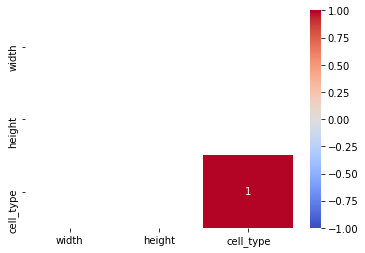

In [19]:
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

Hierboven staat een lege heatmap. Dit geeft aan dat er geen correlaties bevinden in de data. Nu zullen wij verder kijken naar de verdeling van de data we beginen met cell_type

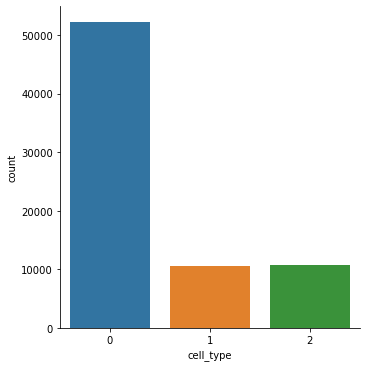

In [20]:
sns.catplot(x='cell_type', data=df,kind='count')  

Hierin valt goed te zien dat de shsy5y cell het meeste voor komt. Hierna komen de andere twee cellen die dicht bij elkaar liggen. Nu zullen we kijken naar de kolommen "elapsed_timedelta", "sample_date" en "plate_time".

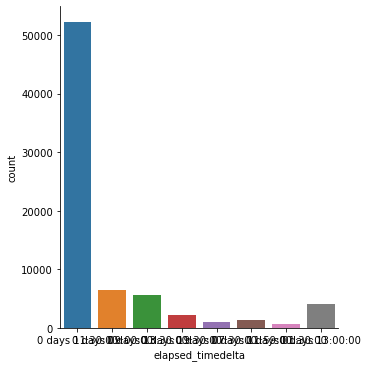

In [21]:
sns.catplot(x='elapsed_timedelta', data=df,kind='count')

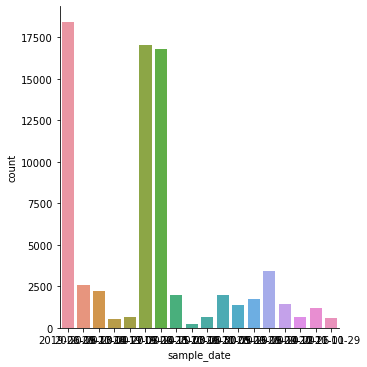

In [22]:
sns.catplot(x='sample_date', data=df,kind='count')

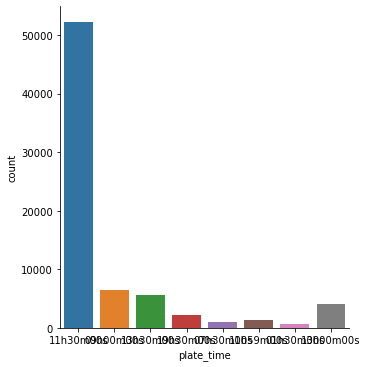

In [23]:
sns.catplot(x='plate_time', data=df,kind='count')

Bovenstaande grafieken geven aan dat de proeven of monsters vaak rond dezelfde tijd gedaan zijn. We gaan nu verder met het verwijderen van kolommen die niet nuttig zijn voor het onderzoek.

In [24]:
def verwijder(dataframe):
    dataframe = df.drop(['elapsed_timedelta'], axis=1)
    dataframe = df.drop(['sample_date'], axis=1)
    dataframe = df.drop(['plate_time'], axis=1)
    dataframe = df.drop(['width'], axis=1)
    dataframe = df.drop(['height'], axis=1)
    return dataframe

In [25]:
df = verwijder(df)

Wij hebben ervoor gekozen om de kolommen "elapsed_timedelta", "sample_date" en "plate_time" te verwijderen omdat dit tijd aangeeft. Dit hebben wij niet nodig voor oons onderzoek. 
Verder hebben wij "Width"en "height" verwijderd. Deze kolommen hebben beide maar 1 waarde en is daarom niet nuttig voor ons om mee te nemen in het onderzoek. Hieronder staat een voorbeeld van de uiteindelijke data set.

In [26]:
df.head(10)

,id,annotation,width,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
5,0030fd0e6378,205984 2 206687 4 207391 5 208095 5 208799 6 2...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
6,0030fd0e6378,203101 2 203805 5 204509 7 205213 10 205917 12...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
7,0030fd0e6378,191900 2 192604 3 193308 4 194012 5 194717 5 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
8,0030fd0e6378,184848 3 185551 5 186254 7 186958 8 187662 9 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
9,0030fd0e6378,165119 1 165822 4 166526 6 167230 9 167935 9 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [27]:
test_set_raw = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\test"
train_set_raw = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train"
train_semi_set_raw = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train_semi_supervised"

In [28]:
def Show_image(path):
    filterwarnings("ignore") 
    tf_img = io.read_file(path)
    tf_img = image.decode_png(tf_img, channels=3)
    #plt.imshow(tf_img)
    return tf_img

In [29]:
def get_img(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in tqdm(filenames):
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
        return image_names

In [30]:
def display_multiple_img(images_paths, rows, cols):
    """
    Function to Display Images from Dataset.
    
    parameters: images_path(string) - Paths of Images to be displayed
                rows(int) - No. of Rows in Output
                cols(int) - No. of Columns in Output
    """
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

In [31]:
test_set = get_img(test_set_raw)
train_set = get_img(train_set_raw)
train_semi_set = get_img(train_semi_set_raw)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/606 [00:00<?, ?it/s]

  0%|          | 0/1972 [00:00<?, ?it/s]

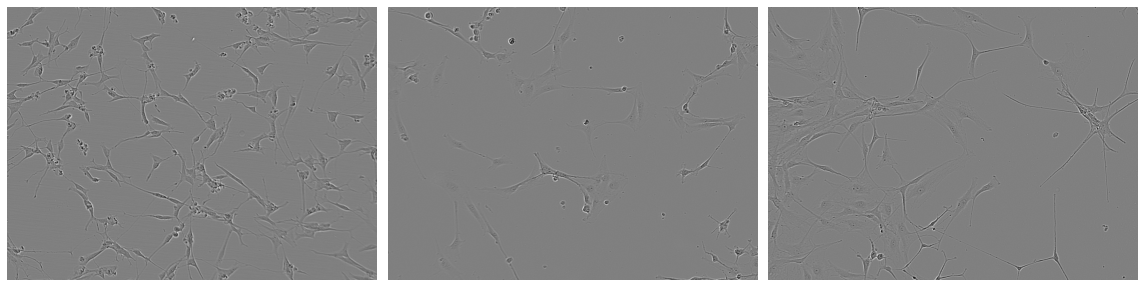

In [32]:
display_multiple_img(test_set,1,3)

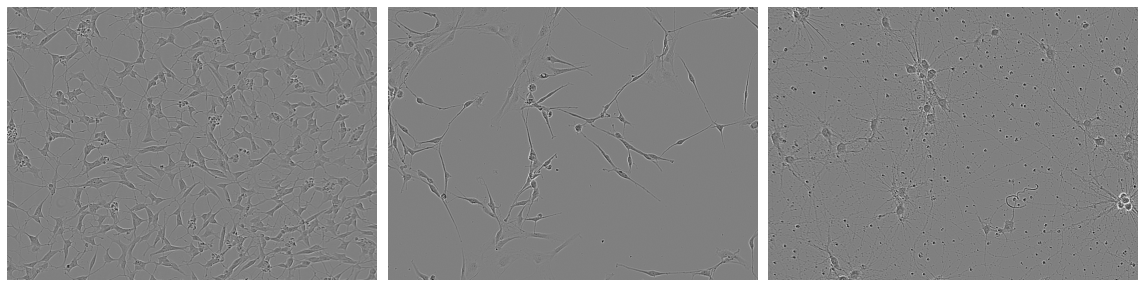

In [33]:
display_multiple_img(train_set,1,3)

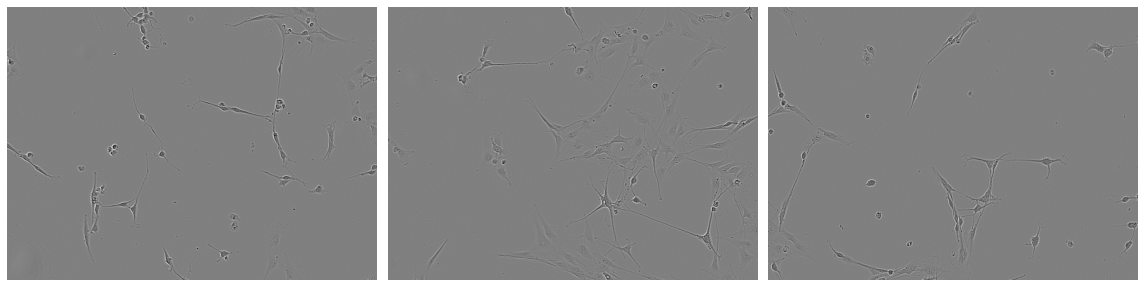

In [34]:
display_multiple_img(train_semi_set,1,3)

In [35]:
imageObject = im.open(r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\ffdb3cc02eef.png");
imageObject.show();

In [36]:
sharpened1 = imageObject.filter(ImageFilter.SHARPEN)
sharpened2 = sharpened1.filter(ImageFilter.SHARPEN)

In [37]:
# sharpened1.show()
# sharpened2.show()

In [38]:
def sharpen(image, aantal):
    imageObject = im.open(image)
    i = 0
    while i > aantal:
        imageObject = imageObject.filter(ImageFilter.SHARPEN)
        imageObject.show()
        i = i + 1
    return imageObject

In [39]:
testImg = plt.imread(r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\ffdb3cc02eef.png")

In [40]:
testImg.shape

(520, 704)

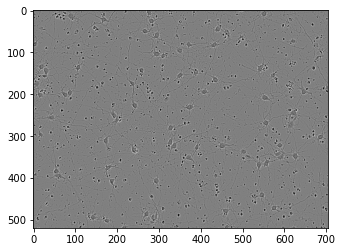

In [41]:
plt.imshow(testImg,cmap='gray')
plt.show()

In [42]:
# Hier maken we de twee kernels aan
Gx = np.matrix([[1,2,1],[0,0,0],[-1,-2,-1]])
Gy = np.matrix.transpose(Gx)
print(Gx)
print(Gy)

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]


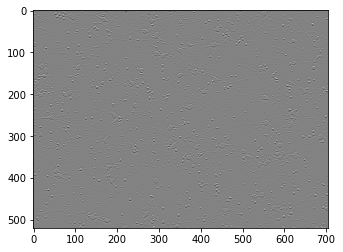

In [43]:
# Pas beide kernels toe in horinzontale en verticale richting
edgex = cv2.filter2D(testImg,-1,Gx)
edgey = cv2.filter2D(testImg,-1,Gy)
plt.imshow(edgex,cmap='gray')
plt.show()

In [44]:
# Neem de som van de kernels en daar de wortel uit. 
w = np.sqrt(np.square(edgex)+np.square(edgey))

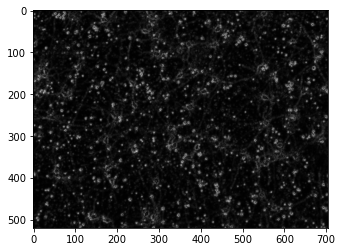

In [45]:
plt.imshow(w,cmap='gray')
plt.show()

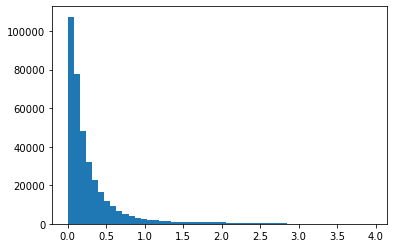

In [46]:
# Gebruik hier thresholding om de edges duidelijker te maken. 
plt.hist(w.flatten(),bins=50)
plt.show()

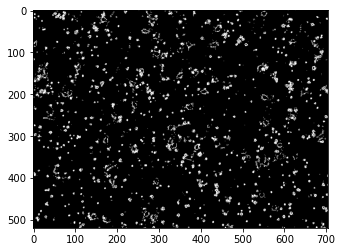

In [47]:
plt.imshow(w>1.0,cmap='gray')
plt.show()

In [48]:
testImg1 = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\ffdb3cc02eef.png"
testTrain = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train"

(Text(0.5, 1.0, 'Edge Image'), ([], []), ([], []))

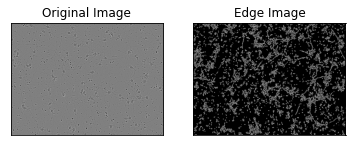

In [49]:
img = cv2.imread(testImg1,0)
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

In [50]:
edges = cv2.Canny(img, 100, 200)

row_indexes, col_indexes = np.nonzero(edges)

In [51]:
def decode_rle_to_mask(rle, height, width, viz=False):
    '''
    rle : run-length as string formated (start value, count)
    height : height of the mask 
    width : width of the mask
    returns binary mask
    '''
    rle = np.array(rle.split(' ')).reshape(-1, 2)
    mask = np.zeros((height*width, 1, 3))
    if viz:
        color = np.random.rand(3)
    else:
        color = [1,1,1]
    for i in rle:
        mask[int(i[0]):int(i[0])+int(i[1]), :, :] = color

    return mask.reshape(height, width, 3)

In [52]:
example_id = "0030fd0e6378.png" # change the example id for different images
example_id2 = "0030fd0e6378"

[[[127 127 127]
  [127 127 127]
  [129 129 129]
  ...
  [129 129 129]
  [127 127 127]
  [128 128 128]]

 [[125 125 125]
  [128 128 128]
  [127 127 127]
  ...
  [132 132 132]
  [126 126 126]
  [126 126 126]]

 [[126 126 126]
  [128 128 128]
  [130 130 130]
  ...
  [129 129 129]
  [130 130 130]
  [131 131 131]]

 ...

 [[130 130 130]
  [131 131 131]
  [129 129 129]
  ...
  [115 115 115]
  [117 117 117]
  [137 137 137]]

 [[129 129 129]
  [129 129 129]
  [128 128 128]
  ...
  [128 128 128]
  [118 118 118]
  [125 125 125]]

 [[128 128 128]
  [128 128 128]
  [128 128 128]
  ...
  [142 142 142]
  [128 128 128]
  [121 121 121]]]
(520, 704, 3)
This is the image we are going to use, id:- C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\ffdb3cc02eef.png


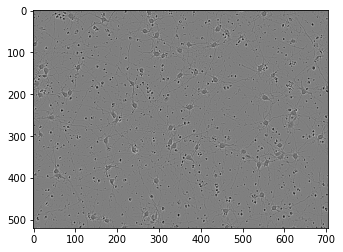

In [53]:
example_id = testImg1 # change the example id for different images
image = cv2.imread(os.path.join(train_set_raw,example_id))
print(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = (image-np.min(image))/(np.max(image)-np.min(image))
print(image.shape)
print("This is the image we are going to use, id:-", example_id)
plt.imshow(image)
plt.show()

The Annotation :  118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4
Now let's convert it to mask and view it


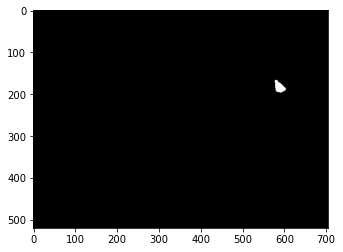

In [54]:
example_annot = df[df.id==example_id2].annotation.values[0]
print("The Annotation : ",example_annot)
print("Now let's convert it to mask and view it")
mask = decode_rle_to_mask(example_annot, image.shape[0], image.shape[1], viz=False)
plt.imshow(mask)
plt.show()

In [55]:
def run_length_decoding(compressed_seq):
  seq = ''
  for i in range(0,len(compressed_seq)):
    if compressed_seq[i].isalpha() == True:
      for j in range(int(compressed_seq[i+1])):
        seq += compressed_seq[i]
 
  return(seq)

In [56]:
run_length_decoding(example_annot)

''

In [57]:
np.set_printoptions(threshold=sys.maxsize)
array = row_indexes,col_indexes

In [58]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [59]:
voorbeeld = encode_mask_to_rle(mask)
voorbeeld

'354436 18 356548 21 358660 24 360772 24 362884 27 364996 30 367108 36 369223 39 371335 42 373447 45 375559 48 377671 51 379783 54 381895 57 384007 60 386119 63 388231 66 390343 69 392455 72 394570 72 396682 75 398794 75 400906 72 403018 72 405130 69 407245 63 409357 57 411472 48 413593 33 415720 12'

In [60]:
example_annot

'118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4'

In [61]:
rle_encoded_row = encode_mask_to_rle(row_indexes)
print(rle_encoded_row)

83 95 274 96 469 96 660 83 845 120 1069 115 1303 114 1528 91 1711 106 1906 105 2110 109 2319 92 2516 86 2684 90 2876 111 3076 88 3253 79 3414 94 3601 98 3784 76 3932 80 4079 66 4234 98 4436 92 4612 80 4783 99 4982 96 5169 76 5319 69 5450 67 5591 89 5762 88 5929 80 6095 109 6297 118 6522 95 6709 84 6877 107 7071 100 7269 82 7449 78 7599 80 7754 79 7931 112 8154 94 8329 77 8472 57 8582 50 8689 64 8840 96 9040 75 9218 83 9375 57 9494 67 9637 107 9819 86 9990 79 10139 71 10270 64 10399 54 10499 47 10593 49 10704 57 10831 61 10958 70 11127 82 11305 92 11487 94 11678 95 11865 94 12065 115 12288 98 12481 77 12628 70 12779 80 12928 64 13062 81 13230 96 13427 93 13618 86 13803 87 13993 91 14186 90 14373 87 14559 103 14764 118 14999 107 15209 86 15380 92 15563 83 15747 94 15942 101 16138 94 16345 102 16567 114 16769 106 16966 105 17164 117 17392 112 17605 107 17827 93 18042 102 18242 78 18403 86 18575 76 18718 66 18834 49 18960 78 19114 71 19265 63 19400 51 19517 63 19625 61 19740 49 19842 49 19

In [62]:
rle_encoded_col = encode_mask_to_rle(col_indexes)
print(rle_encoded_col)

1 1 3 1 5 1 7 1 9 1 11 1 13 1 15 1 17 1 19 1 21 1 23 1 25 1 27 1 29 1 31 1 33 1 35 1 37 1 39 1 41 1 43 1 45 1 47 1 49 1 51 1 53 1 55 1 57 1 59 1 61 1 63 1 65 1 67 1 69 1 71 1 73 1 75 1 77 1 79 1 81 1 83 1 85 1 87 1 89 1 91 1 93 1 95 1 97 1 99 1 101 1 103 1 105 1 107 1 109 1 111 1 113 1 115 1 117 1 119 1 121 1 123 1 125 1 127 1 129 1 131 1 133 1 135 1 137 1 139 1 141 1 143 1 145 1 147 1 149 1 151 1 153 1 155 1 157 1 159 1 161 1 163 1 165 1 167 1 169 1 171 1 173 1 175 1 177 1 179 1 181 1 183 1 185 1 187 1 189 1 191 1 193 1 195 1 197 1 199 1 201 1 203 1 205 1 207 1 209 1 211 1 213 1 215 1 217 1 219 1 221 1 223 1 225 1 227 1 229 1 231 1 233 1 235 1 237 1 239 1 241 1 243 1 245 1 247 1 249 1 251 1 253 1 255 1 257 1 259 1 261 1 263 1 265 1 267 1 269 1 271 1 273 1 275 1 277 1 279 1 281 1 283 1 285 1 287 1 289 1 291 1 293 1 295 1 297 1 299 1 301 1 303 1 305 1 307 1 309 1 311 1 313 1 315 1 317 1 319 1 321 1 323 1 325 1 327 1 329 1 331 1 333 1 335 1 337 1 339 1 341 1 343 1 345 1 347 1 349 1 351 1

In [63]:
rle_encoded_row,rle_encoded_col

('83 95 274 96 469 96 660 83 845 120 1069 115 1303 114 1528 91 1711 106 1906 105 2110 109 2319 92 2516 86 2684 90 2876 111 3076 88 3253 79 3414 94 3601 98 3784 76 3932 80 4079 66 4234 98 4436 92 4612 80 4783 99 4982 96 5169 76 5319 69 5450 67 5591 89 5762 88 5929 80 6095 109 6297 118 6522 95 6709 84 6877 107 7071 100 7269 82 7449 78 7599 80 7754 79 7931 112 8154 94 8329 77 8472 57 8582 50 8689 64 8840 96 9040 75 9218 83 9375 57 9494 67 9637 107 9819 86 9990 79 10139 71 10270 64 10399 54 10499 47 10593 49 10704 57 10831 61 10958 70 11127 82 11305 92 11487 94 11678 95 11865 94 12065 115 12288 98 12481 77 12628 70 12779 80 12928 64 13062 81 13230 96 13427 93 13618 86 13803 87 13993 91 14186 90 14373 87 14559 103 14764 118 14999 107 15209 86 15380 92 15563 83 15747 94 15942 101 16138 94 16345 102 16567 114 16769 106 16966 105 17164 117 17392 112 17605 107 17827 93 18042 102 18242 78 18403 86 18575 76 18718 66 18834 49 18960 78 19114 71 19265 63 19400 51 19517 63 19625 61 19740 49 19842 49 

In [64]:
def run_length_encoding(seq):
  compressed = []
  count = 1
  char = seq[0]
  for i in range(1,len(seq)):
    if seq[i] == char:
      count = count + 1
    else :
      compressed.append([char,count])
      char = seq[i]
      count = 1
  compressed.append([char,count])
  return compressed

In [65]:
seq = row_indexes
list1 = run_length_encoding(seq)
list1

[[0, 82],
 [1, 95],
 [2, 96],
 [3, 96],
 [4, 99],
 [5, 96],
 [6, 95],
 [7, 83],
 [8, 102],
 [9, 120],
 [10, 104],
 [11, 115],
 [12, 119],
 [13, 114],
 [14, 111],
 [15, 91],
 [16, 92],
 [17, 106],
 [18, 89],
 [19, 105],
 [20, 99],
 [21, 109],
 [22, 100],
 [23, 92],
 [24, 105],
 [25, 86],
 [26, 82],
 [27, 90],
 [28, 102],
 [29, 111],
 [30, 89],
 [31, 88],
 [32, 89],
 [33, 79],
 [34, 82],
 [35, 94],
 [36, 93],
 [37, 98],
 [38, 85],
 [39, 76],
 [40, 72],
 [41, 80],
 [42, 67],
 [43, 66],
 [44, 89],
 [45, 98],
 [46, 104],
 [47, 92],
 [48, 84],
 [49, 80],
 [50, 91],
 [51, 99],
 [52, 100],
 [53, 96],
 [54, 91],
 [55, 76],
 [56, 74],
 [57, 69],
 [58, 62],
 [59, 67],
 [60, 74],
 [61, 89],
 [62, 82],
 [63, 88],
 [64, 79],
 [65, 80],
 [66, 86],
 [67, 109],
 [68, 93],
 [69, 118],
 [70, 107],
 [71, 95],
 [72, 92],
 [73, 84],
 [74, 84],
 [75, 107],
 [76, 87],
 [77, 100],
 [78, 98],
 [79, 82],
 [80, 98],
 [81, 78],
 [82, 72],
 [83, 80],
 [84, 75],
 [85, 79],
 [86, 98],
 [87, 112],
 [88, 111],
 [89, 94

In [67]:
list1[0]

TypeError: list indices must be integers or slices, not tuple